In [ ]:

!pip install pyspark
from pyspark.sql import SparkSession


spark = (SparkSession.builder.appName("itoss-ai")
         .config("spark.jars","./postgresql-42.7.3.jar")
         .config("spark.sql.debug.maxToStringFields", "1024")
       
         .getOrCreate())

In [ ]:
jdbcUrl = "jdbc:postgresql://localhost:5432/itossprd040924"
properties = {
    "driver": "org.postgresql.Driver",
    "user": "itoss",
    "password": "admin"
}

In [ ]:
cts_df = spark.read.jdbc(url=jdbcUrl, table="""
(SELECT
                     c.id,
                     c.key,
                     c.environment,
                     c.state,
                     c.name,
                     c.collector_id,
                     c.company_id,
                     c.contact_id,
                     c.location_id,
                     c.monitoring_profile_id,
                     c.support_user_id,
                     c.type_id,
                     c.workgroup_id,
                     CASE
                         WHEN environment = 'PRODUCTION' THEN 'production'
                         ELSE 'nonProduction'
                     END AS environment_group,
                     ct.name AS type_name,
                     ct.type_path AS type_path,
                     co.name AS company_name,
                     w.name AS workgroup_name,
                     l.name AS location_name,
                     mp.name AS monitoring_profile_name,
                     cl.name AS collector_name,
                     ARRAY_AGG(tu.users_id::BIGINT) AS users_id
                 FROM
                     ct c
                 INNER JOIN
                     workgroup w ON c.workgroup_id = w.id
                 INNER JOIN
                     location l ON c.location_id = l.id
                 INNER JOIN
                     ct_type ct ON c.type_id = ct.id
                 INNER JOIN
                     company co ON c.company_id = co.id
                 INNER JOIN
                     collector cl ON c.collector_id = cl.id
                 INNER JOIN
                     monitoring_profile mp ON c.monitoring_profile_id = mp.id
                 INNER JOIN
                     tennant_cts tc ON c.id = tc.cts_id
                 INNER JOIN
                     tennant_users tu ON tc.tennant_id = tu.tennant_id
                 GROUP BY
                     c.id,
                     c.key,
                     c.environment,
                     c.state,
                     c.name,
                     c.collector_id,
                     c.company_id,
                     c.contact_id,
                     c.location_id,
                     c.monitoring_profile_id,
                     c.support_user_id,
                     c.type_id,
                     c.workgroup_id,
                     ct.name,
                     ct.type_path,
                     co.name,
                     w.name,
                     l.name,
                     mp.name,
                     cl.name
                 ) as subquery""", properties=properties)
cts_df.printSchema()

In [ ]:
from pyspark.sql import functions
cts_just_id_df = cts_df.filter("state = 'OPERATIONS'").filter(functions.array_contains(functions.col("users_id"), 200000))

In [ ]:
status_all = spark.read.jdbc(url=jdbcUrl, table="ct_status_all", properties=properties)

In [ ]:
filtered_df = status_all.alias('s') \
    .join(cts_df.alias('ct'), col('s.ct_id') == col('ct.id'))
filtered_df.printSchema()

    

## Esta es la solución para calculo de diferencias entre periodos   

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import col, current_timestamp, max, count, lit, expr, when, round, abs

# Define the conditions for each period with an associated numeric order
conditions = [
    ('now', current_timestamp(), 1),
    ('last_hour', current_timestamp() - expr("INTERVAL 1 HOUR"), 2),
    ('last_day', current_timestamp() - expr("INTERVAL 1 DAY"), 3),
    ('last_week', current_timestamp() - expr("INTERVAL 1 WEEK"), 4),
    ('last_month', current_timestamp() - expr("INTERVAL 1 MONTH"), 5)
]

# Initialize an empty DataFrame to store the results
final_df = None

# Separate the calculation for the 'now' period
now_df = filtered_df.filter(col('timestamp') < conditions[0][1]) \
    .groupBy('ct_id', 'status') \
    .agg(max('timestamp').alias('max_timestamp')) \
    .groupBy('status') \
    .agg(count('*').alias('qty')) \
    .withColumn('period', lit(conditions[0][0])) \
    .withColumn('period_order', lit(conditions[0][2]))

# Create the calculations for the other periods
for period_name, condition, period_order in conditions[1:]:
    temp_df = filtered_df.filter(col('timestamp') < condition) \
        .groupBy('ct_id', 'status') \
        .agg(max('timestamp').alias('max_timestamp')) \
        .groupBy('status') \
        .agg(count('*').alias('qty')) \
        .withColumn('period', lit(period_name)) \
        .withColumn('period_order', lit(period_order))
    
    if final_df is None:
        final_df = temp_df
    else:
        final_df = final_df.union(temp_df)

# Join the final_df with the now_df to calculate the difference based on the 'now' period
final_df = final_df.join(now_df.select('status', col('qty').alias('now_qty')), on='status')

# Calculate the difference between the 'now' qty and the other periods
final_df = final_df.withColumn('difference', col('qty') - col('now_qty'))

final_df = final_df.withColumn('percent_difference', round(when(col('now_qty') == 0, 0).otherwise(col('difference') / col('now_qty') * 100), 2))
final_df = final_df.withColumn('trend', when(col('difference') > 0, 'up').when(col('difference') < 0, 'down').otherwise('stable'))

# get absolute percent without sign
final_df = final_df.withColumn('percent_difference', abs(col('percent_difference')))

# Drop the helper column 'period_order' and 'now_qty'
final_df = final_df.drop('period_order', 'now_qty')

# Now create the same calculations but include the 'environment_group' column
final_env_df = None

# Separate the calculation for the 'now' period with 'environment_group'
now_env_df = filtered_df.filter(col('timestamp') < conditions[0][1]) \
    .groupBy('ct_id', 'status', 'environment_group') \
    .agg(max('timestamp').alias('max_timestamp')) \
    .groupBy('status', 'environment_group') \
    .agg(count('*').alias('qty')) \
    .withColumn('period', lit(conditions[0][0])) \
    .withColumn('period_order', lit(conditions[0][2]))

for period_name, condition, period_order in conditions[1:]:
    temp_env_df = filtered_df.filter(col('timestamp') < condition) \
        .groupBy('ct_id', 'status', 'environment_group') \
        .agg(max('timestamp').alias('max_timestamp')) \
        .groupBy('status', 'environment_group') \
        .agg(count('*').alias('qty')) \
        .withColumn('period', lit(period_name)) \
        .withColumn('period_order', lit(period_order))
    
    if final_env_df is None:
        final_env_df = temp_env_df
    else:
        final_env_df = final_env_df.union(temp_env_df)

# Join the final_env_df with the now_env_df to calculate the difference based on the 'now' period
final_env_df = final_env_df.join(now_env_df.select('status', 'environment_group', col('qty').alias('now_qty')), 
                                 on=['status', 'environment_group'])

# Calculate the difference between the 'now' qty and the other periods
final_env_df = final_env_df.withColumn('difference', col('qty') - col('now_qty'))

final_env_df = final_env_df.withColumn('percent_difference', round(when(col('now_qty') == 0, 0).otherwise(col('difference') / col('now_qty') * 100), 2))
final_env_df = final_env_df.withColumn('trend', when(col('difference') > 0, 'up').when(col('difference') < 0, 'down').otherwise('stable'))

# get absolute percent without sign
final_env_df = final_env_df.withColumn('percent_difference', abs(col('percent_difference')))

# Drop the helper column 'period_order' and 'now_qty'
final_env_df = final_env_df.drop('period_order', 'now_qty')

# Show the results
final_df.show()
final_env_df.show()




## Solucion para status por environment y periodo

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import col, current_timestamp, max, count, lit, expr, lag, when, round, abs

# Define the conditions for each period with an associated numeric order
conditions = [
    ('now', current_timestamp(), 1),
    ('last_hour', current_timestamp() - expr("INTERVAL 1 HOUR"), 2),
    ('last_day', current_timestamp() - expr("INTERVAL 1 DAY"), 3),
    ('last_week', current_timestamp() - expr("INTERVAL 1 WEEK"), 4),
    ('last_month', current_timestamp() - expr("INTERVAL 1 MONTH"), 5)
]

# Initialize an empty DataFrame to store the results
final_df = None

for period_name, condition, period_order in conditions:
    temp_df = filtered_df.filter(col('timestamp') < condition) \
        .groupBy('ct_id', 'status', "environment_group") \
        .agg(max('timestamp').alias('max_timestamp')) \
        .groupBy('status','environment_group') \
        .agg(count('*').alias('qty')) \
        .withColumn('period', lit(period_name)) \
        .withColumn('period_order', lit(period_order))
    
    if final_df is None:
        final_df = temp_df
    else:
        final_df = final_df.union(temp_df)

# Define a window specification to partition by status and order by period_order
window_spec = Window.partitionBy('status').orderBy(col('period_order').desc())

# Calculate the difference between the current and previous periods
final_df = final_df.withColumn('prev_qty', lag('qty').over(window_spec)) \
    .withColumn('difference', col('qty') - col('prev_qty'))

final_df = final_df.withColumn('percent_difference', round(when(col('prev_qty') == 0, 0).otherwise(col('difference') / col('prev_qty') * 100),2))
final_df = final_df.withColumn('trend', when(col('difference') > 0, 'up').when(col('difference') < 0, 'down').otherwise('stable'))

# get absolute percent without sign

final_df = final_df.withColumn('percent_difference', abs(col('percent_difference')))



# Drop the helper column 'period_order'
final_df = final_df.drop('period_order')

# Show the result with differences
final_df.show()

## Calculo de concentración de status por hora del día


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, count

# Extraer la hora del día de la columna timestamp
df = filtered_df.withColumn("hour_of_day", hour(filtered_df["timestamp"]))

# Agrupar por hora del día y estado, y contar las ocurrencias
distribution_df = df.groupBy("hour_of_day", "status").agg(count("ct_id").alias("count"))

# Mostrar los resultados
distribution_df.filter("status == 'down'").orderBy("hour_of_day").show(48)


## Calculo de monitor ct status por criticidad


In [ ]:
cts_mgmt_status_df = spark.read.jdbc(url=jdbcUrl, 
                table="""
                (select ms.*,
                 CASE WHEN (ms.total_monitors_ok + ms.total_monitors_fault - ms.total_exclude_monitors_ok) = 0 THEN 0
                        ELSE (100 * ms.total_monitors_fault / (ms.total_monitors_ok - ms.total_exclude_monitors_ok + ms.total_monitors_fault))
                    END AS fault,
                    CASE WHEN (ms.total_monitors_fault = 0) THEN 'OK'
                        WHEN ((ms.total_monitors_ok - ms.total_exclude_monitors_ok) = 0) THEN 'CRITICAL'
                        WHEN ((100 * ms.total_monitors_fault / (ms.total_monitors_ok - ms.total_exclude_monitors_ok + ms.total_monitors_fault)) < 50) THEN 'MEDIUM'
                        WHEN ((100 * ms.total_monitors_fault / (ms.total_monitors_ok - ms.total_exclude_monitors_ok + ms.total_monitors_fault)) >= 50) THEN 'HIGH'                                               
                    END AS management_status
                 from (SELECT ct.id as ct_id,COUNT(mcs.*) FILTER (WHERE mcs.status = 'OK' AND me.metric_category IN ('Availability', 'Status')) total_exclude_monitors_ok,
                                         COUNT(mcs.*) FILTER (WHERE mcs.status = 'OK' OR mcs.status = 'SECONDARY_FAULT') total_monitors_ok,
                                         COUNT(mcs.*) FILTER (WHERE mcs.status = 'FAULT') total_monitors_fault,
                                         CAST(JSON_AGG(
                                            jsonb_build_object('id', m.id) ||
                                            jsonb_build_object('last_change', mcs.last_change::timestamp AT TIME ZONE 'UTC') ||
                                            jsonb_build_object('name', m.name) || 
                                            jsonb_build_object('metric_category', me.metric_category) || 
                                            jsonb_build_object('last_update', mcs.modified_at::timestamp AT TIME ZONE 'UTC') || 
                                            jsonb_build_object('status', mcs.status) || jsonb_build_object('error', mcs.error) ORDER BY m.name ASC) AS VARCHAR) monitors
                                                                      
                                    FROM ct ct
                                         LEFT JOIN monitor_ct_status mcs ON mcs.ct_id = ct.id
                                         LEFT JOIN monitor m ON m.id = mcs.monitor_id  
                                         LEFT JOIN metric me ON me.id = m.metric_id     
                                    WHERE ct.state = 'OPERATIONS'                                        
                                GROUP BY ct.id ) as ms) as query 
                """, properties=properties)
cts_mgmt_status_df.printSchema()
cts_mgmt_status_df.show(10,truncate=False)

In [ ]:
cts_mgmt_status_totals_df = cts_mgmt_status_df.groupBy("management_status").count()
cts_mgmt_status_totals_df.show()

In [ ]:
from pyspark.sql.functions import col, explode, from_json
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, TimestampType

# Define the schema of the JSON array elements in the monitors column
monitor_schema = ArrayType(StructType([
    StructField("id", StringType(), True),
    StructField("last_change", TimestampType(), True),
    StructField("name", StringType(), True),
    StructField("metric_category", StringType(), True),
    StructField("last_update", TimestampType(), True),
    StructField("status", StringType(), True),
    StructField("error", StringType(), True)
]))

# Parse the monitors column from JSON string to array of structs
cts_mgmt_status_df = cts_mgmt_status_df.withColumn("monitors_array", from_json(col("monitors"), monitor_schema))

# Filter records where management_status is 'CRITICAL'
critical_df = cts_mgmt_status_df.filter(col("management_status") == "CRITICAL")

# Explode the monitors_array column to get each monitor as a separate row
exploded_df = critical_df.withColumn("monitor", explode(col("monitors_array")))

# Select the monitor ID and last_change timestamp
result_df = exploded_df.select(col("ct_id"),col("monitor.id").alias("monitor_id"), col("monitor.last_change"))

# Show the result


In [ ]:
result_df.groupBy("ct_id").count().show()

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("ClusteringExample").getOrCreate()

# Ensure all columns are of type double
df = cts_df.withColumn("collector_id", cts_df["collector_id"].cast("double")) \
           .withColumn("company_id", cts_df["company_id"].cast("double")) \
           .withColumn("location_id", cts_df["location_id"].cast("double")) \
           .withColumn("type_id", cts_df["type_id"].cast("double")) \
           .withColumn("workgroup_id", cts_df["workgroup_id"].cast("double")) \
           .withColumn("support_user_id", cts_df["support_user_id"].cast("double"))

# Fill null values
df = df.na.fill(0, ["collector_id", "company_id", "location_id", "type_id", "workgroup_id", "support_user_id"])

# Assemble features into a feature vector
assembler = VectorAssembler(inputCols=["collector_id", "company_id", "location_id", 
                                       "type_id", "workgroup_id", "support_user_id"],
                            outputCol="features")
feature_df = assembler.transform(df)

# Apply K-Means clustering
kmeans = KMeans(k=5, seed=1)  # Adjust the number of clusters (k)
model = kmeans.fit(feature_df)

# Make predictions (assign clusters to data points)
predictions = model.transform(feature_df)

# Apply PCA to reduce dimensions to 2
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(feature_df)
pca_result = pca_model.transform(feature_df)

# Join PCA results with predictions
pca_result_with_predictions = pca_result.join(predictions.select("id", "prediction"), on="id")

# Convert to Pandas DataFrame for plotting
pandas_df = pca_result_with_predictions.select("pca_features", "prediction").toPandas()

# Extract the two dimensions and the cluster labels
pandas_df['pca1'] = pandas_df['pca_features'].apply(lambda x: x[0])
pandas_df['pca2'] = pandas_df['pca_features'].apply(lambda x: x[1])
pandas_df['cluster'] = pandas_df['prediction']

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['pca1'], pandas_df['pca2'], c=pandas_df['cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title('Cluster Concentration with PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()



In [ ]:
!pip install pyspark transformers torch
from pyspark.sql import SparkSession
from transformers import pipeline

# Initialize Spark session
spark = SparkSession.builder.appName("GenerativeAIExample").getOrCreate()

# Load a pre-trained text generation model (e.g., GPT-2)
text_generator = pipeline("text-generation", model="gpt2")

# Example data
data = [
    {"id": 1, "input_text": "The future of AI in healthcare is"},
    {"id": 2, "input_text": "Data-driven decision making will"},
]

# Create a DataFrame
df = spark.createDataFrame(data)

# Show the input data
df.show()


In [ ]:
import plotly.express as px
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

# Filter to include only the "down" statuses and group by relevant features
down_df = filtered_df.filter(col("status") == "down").groupBy(
    "status", "location_id", "company_id", "location_name", "company_name"
).agg(
    count("*").alias("count")
)

# Assemble features into a feature vector (including the 'count' of downs)
assembler = VectorAssembler(inputCols=["location_id", "company_id", "count"],
                            outputCol="features")
assembled_df = assembler.transform(down_df)

# Apply K-Means clustering
kmeans = KMeans(k=5, seed=1)  # Adjust the number of clusters (k) as needed
model = kmeans.fit(assembled_df)

# Make predictions (assign clusters to data points)
predictions = model.transform(assembled_df)

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(predictions)
pca_result = pca_model.transform(predictions)

# Convert to Pandas DataFrame for plotting
pandas_df = pca_result.select("pca_features", "prediction", "location_name", "company_name", "count").toPandas()

# Extract the two dimensions and cluster labels
pandas_df['pca1'] = pandas_df['pca_features'].apply(lambda x: x[0])
pandas_df['pca2'] = pandas_df['pca_features'].apply(lambda x: x[1])
pandas_df['cluster'] = pandas_df['prediction']

# Concatenate labels for display, including the count
pandas_df['label'] = pandas_df.apply(lambda row: f"{row['location_name']} - {row['company_name']} (Count: {row['count']})", axis=1)

# Create an interactive scatter plot using Plotly
hover_data = {
    'location_name': True,
    'company_name': True,
    'count': True,  # Show the count in the hover data
    'pca1': False,  # Set to False if you don't want to show PCA component values
    'pca2': False
}

fig = px.scatter(
    pandas_df,
    x='pca1',
    y='pca2',
    color='cluster',
    hover_name='label',  # Shows the concatenated label when hovering
    hover_data=hover_data,
    title="Down Components Clustering",
    labels={'pca1': 'PCA Component 1', 'pca2': 'PCA Component 2', 'cluster': 'Cluster'},
    template='plotly_dark'  # Optional: Choose a theme like 'plotly_dark'
)

# Update the marker style if needed
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Update layout for better visibility
fig.update_layout(
    title="Down Components Clustering with Interactive Labels",
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    legend_title="Cluster",
    hovermode="closest"
)

# Show the interactive plot
fig.show()





In [ ]:
history_df = spark.read.jdbc(url=jdbcUrl, table="""
(select count(*), CURRENT_TIMESTAMP as now, (CURRENT_TIMESTAMP - INTERVAL '30 days') last30 from (select m.id monitor_id,
                       ct_id,
                       m.name monitor_name,
                       m.metric_id,
                       tmp.metric metric_name,
                       tmp.timestamp timestamp,
                       count(tmp.*) as count_dashboard_entries
                       --(count(tmp.*) / SUM(count(tmp.*)) OVER ()) * 100 AS percentage_dashboard_entries
                       --count(distinct ct_id) as count_cts,
                       --count(distinct company_id) as count_company
                from (select "metric"->>'value' as "metric",
                             "metric_payload_data"->'value'->>'monitorId' as "monitor_id",
                             "event_rule"->>'value' as "event_rule",
                             "severity"->>'value' as "severity",
                             ch."attributes",
                             ch.*,
                             co.id company_id
                      from ct_history ch
                               inner join ct c on c.id = ch.ct_id
                               inner join company co on co.id = c.company_id
                
                         ,jsonb_array_elements(ch.attributes) as "metric"
                         ,jsonb_array_elements(ch.attributes) as "metric_payload_data"
                         ,jsonb_array_elements(ch.attributes) as "event_rule"
                         ,jsonb_array_elements(ch.attributes) as "severity"
                      where ch.event = 'ATTEND'
                        and ch.timestamp >= (CURRENT_TIMESTAMP - INTERVAL '30 days')
                        and "metric"->>'name' = 'metric'
                        and "metric_payload_data"->>'name' = 'metric_payload_data'
                        and "event_rule"->>'name' = 'event_rule'
                        and "severity"->>'name' = 'severity') as tmp
                         inner join monitor m on tmp.monitor_id::int = m.id
                group by ct_id, m.id, m.name, metric_id,metric_name,timestamp) as subquery) query2""", properties=properties)

In [ ]:
history_df.show(truncate=False)


In [ ]:
history_view_df = spark.read.jdbc(url=jdbcUrl, table="monitors_attended_last30", properties=properties)

In [ ]:
history_view_df.show(truncate=False)

In [46]:
status_all = spark.read.jdbc(url=jdbcUrl, table="ct_status_all", properties=properties)

In [ ]:
status_all.printSchema()
status_all.show(5)

In [47]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Define the window partitioned by ct_id and status, ordered by timestamp
window_spec = Window.partitionBy("ct_id", "status").orderBy(F.col("timestamp"))

# Calculate the lag of the timestamp for comparison
df_with_lag = status_all.withColumn("prev_timestamp", F.lag("timestamp").over(window_spec))

# Filter out rows where the difference between the current and previous timestamp is less than or equal to 1 minute
df_filtered = df_with_lag.withColumn(
    "time_diff", 
    F.col("timestamp").cast("long") - F.col("prev_timestamp").cast("long")
).filter(
    (F.col("prev_timestamp").isNull()) | (F.col("time_diff") > 60)
)

# Select the necessary columns and drop intermediate columns
result_df = df_filtered.select("timestamp", "status", "ct_id")
result_df.printSchema()
result_df.orderBy("ct_id").show(truncate=False)


root
 |-- timestamp: timestamp (nullable = true)
 |-- status: string (nullable = true)
 |-- ct_id: long (nullable = true)

+--------------------------+------+------+
|timestamp                 |status|ct_id |
+--------------------------+------+------+
|2024-06-25 19:04:14.079   |up    |200002|
|2024-02-29 22:04:14.272   |up    |200027|
|2024-03-11 19:16:14.576   |up    |200028|
|2024-04-11 19:48:14.496   |up    |200029|
|2024-06-05 21:50:14.289   |up    |200032|
|2024-09-03 13:10:47.569593|down  |200033|
|2024-09-03 13:08:47.700614|down  |200034|
|2024-02-28 20:12:16.013   |up    |200035|
|2024-04-24 00:04:17.947   |up    |200036|
|2024-04-24 00:04:17.955   |up    |200037|
|2024-09-02 15:14:47.029979|down  |200040|
|2024-09-02 15:40:14.237   |up    |200040|
|2024-02-28 20:12:15.95    |up    |200041|
|2024-09-03 13:08:47.559594|down  |200042|
|2024-02-28 20:12:16.012   |up    |200043|
|2024-04-24 00:04:17.943   |up    |200044|
|2024-06-12 01:00:14.299   |up    |200045|
|2024-04-24 00:04

root
 |-- day: string (nullable = true)
 |-- total_up: long (nullable = true)
 |-- total_down: long (nullable = true)
 |-- total_cts: long (nullable = true)
 |-- percent_up: double (nullable = true)
 |-- percent_down: double (nullable = true)
 |-- efficiency_score: double (nullable = true)

+----------+--------+----------+---------+----------+------------+----------------+
|day       |total_up|total_down|total_cts|percent_up|percent_down|efficiency_score|
+----------+--------+----------+---------+----------+------------+----------------+
|2024-08-21|7226    |779       |8005     |90.27     |9.73        |90.27           |
|2024-08-22|7295    |786       |8081     |90.27     |9.73        |90.27           |
|2024-08-23|7396    |787       |8183     |90.38     |9.62        |90.38           |
|2024-08-24|7514    |788       |8302     |90.51     |9.49        |90.51           |
|2024-08-25|7580    |790       |8370     |90.56     |9.44        |90.56           |
|2024-08-26|7607    |790       |8397

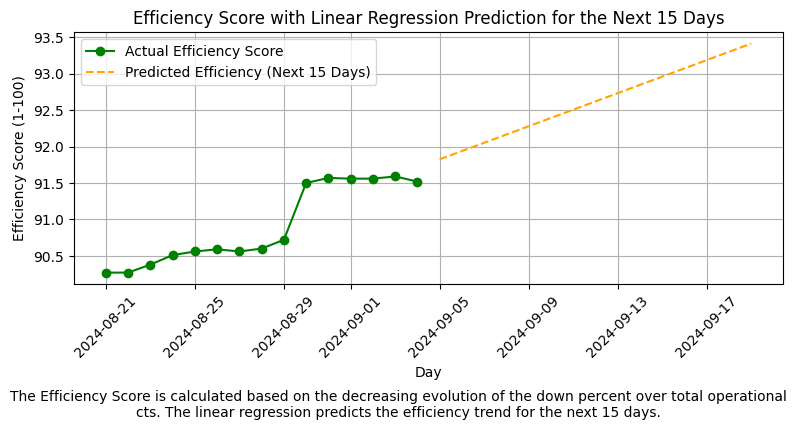

In [49]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StringType, StructType
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# Step 1: Get the latest timestamp in the dataset
latest_timestamp = result_df.agg(F.max("timestamp")).collect()[0][0]

# Step 2: Generate a sequence of days, starting 14 days before the latest timestamp (total 15 days)
end_date = latest_timestamp.date()
start_date = end_date - timedelta(days=14)

days_list = [(str(start_date + timedelta(days=i)),) for i in range(15)]  # 15 days total
schema = StructType().add("day", StringType())
days_df = spark.createDataFrame(days_list, schema)

# Step 3: Create a window specification to order by timestamp and partition by ct_id
window_spec = Window.partitionBy("ct_id").orderBy(F.col("timestamp").desc())

# Step 4: Cross join the days DataFrame with result_df and filter by day
df_with_days = result_df.crossJoin(days_df) \
    .filter(F.col("timestamp") < F.to_timestamp(F.col("day"), "yyyy-MM-dd")) \
    .withColumn("rn", F.row_number().over(window_spec)) \
    .filter(F.col("rn") == 1)

# Step 5: Aggregate the status for each day per ct_id, counting 'up' and 'down' statuses
daily_status = df_with_days.groupBy("day").agg(
    F.sum(F.when(F.col("status") == "up", 1).otherwise(0)).alias("up"),
    F.sum(F.when(F.col("status") == "down", 1).otherwise(0)).alias("down")
)

# Step 6: Define a window for cumulative sum
day_window_spec = Window.orderBy("day").rowsBetween(Window.unboundedPreceding, Window.currentRow)

# Step 7: Apply window function to calculate cumulative sums
result = daily_status.withColumn("total_up", F.sum("up").over(day_window_spec)) \
                     .withColumn("total_down", F.sum("down").over(day_window_spec)) \
                     .select("day", "total_up", "total_down") \
                     .orderBy("day")

# Step 8: Add a column for the total (sum of ups and downs) for each day
result_with_total = result.withColumn("total_cts", F.col("total_up") + F.col("total_down"))

# Step 9: Calculate the percentage of ups and downs over the total and round to 2 decimals
result_with_percent = result_with_total.withColumn("percent_up", F.round((F.col("total_up") / F.col("total_cts")) * 100, 2)) \
                                       .withColumn("percent_down", F.round((F.col("total_down") / F.col("total_cts")) * 100, 2))

# Step 10: Calculate an efficiency score (scaled between 1 and 100) and round to 2 decimals
result_with_efficiency = result_with_percent.withColumn("efficiency_score", 
    F.round(F.when(F.col("percent_down") > 0, 100 - F.col("percent_down")).otherwise(100), 2))

# Step 11: Print the schema and columns to check for correctness
result_with_efficiency.printSchema()  # Check if efficiency_score exists
result_with_efficiency.show(truncate=False)  # View the DataFrame to confirm

# Step 12: Convert to a format suitable for MLlib
result_with_efficiency = result_with_efficiency.withColumn("day_index", F.row_number().over(Window.orderBy("day")) - 1)

# Step 13: Assemble features for MLlib (day index as feature, efficiency score as label)
assembler = VectorAssembler(inputCols=["day_index"], outputCol="features")
data_for_regression = assembler.transform(result_with_efficiency).select("features", "efficiency_score")

# Step 14: Train the linear regression model using Spark MLlib
lr = LinearRegression(featuresCol="features", labelCol="efficiency_score")
lr_model = lr.fit(data_for_regression)

# Step 15: Predict efficiency for the next 15 days using the linear regression model
# Generate next 15 days as day_index (starting from 15th day to 29th day)
next_15_days = spark.createDataFrame([(i,) for i in range(15, 30)], ["day_index"])

# Assemble features for next 15 days
next_15_days_assembled = assembler.transform(next_15_days)

# Predict efficiency scores for the next 15 days
predictions = lr_model.transform(next_15_days_assembled)

# Step 16: Collect predicted values and combine with original data
predicted_efficiency = predictions.select("day_index", "prediction").toPandas()

# Fix: Convert 'day' to datetime and generate next 15 days correctly
latest_day = pd.to_datetime(result_with_efficiency.agg(F.max("day")).collect()[0][0])
predicted_efficiency['day'] = pd.date_range(start=latest_day + timedelta(days=1), periods=15)

# Collect original data for plotting
pandas_df = result_with_efficiency.select("day", "efficiency_score").toPandas()
pandas_df['day'] = pd.to_datetime(pandas_df['day'])

# Combine original and predicted data
combined_df = pd.concat([pandas_df, predicted_efficiency.rename(columns={"prediction": "efficiency_score"})])

# Step 17: Plot the efficiency score and the linear regression prediction
plt.figure(figsize=(8, 4))

# Plot the actual efficiency scores
plt.plot(pandas_df['day'], pandas_df['efficiency_score'], label='Actual Efficiency Score', marker='o', color='green')

# Plot the predicted efficiency scores (handle if column name mismatch occurs)
plt.plot(predicted_efficiency.get('day'), predicted_efficiency.get('prediction'), label='Predicted Efficiency (Next 15 Days)', linestyle='--', color='orange')

plt.xlabel('Day')
plt.ylabel('Efficiency Score (1-100)')
plt.title('Efficiency Score with Linear Regression Prediction for the Next 15 Days')
plt.legend()

# Add explanation text in the graph
plt.figtext(0.5, -0.05, 
            "The Efficiency Score is calculated based on the decreasing evolution of the down percent over total operational cts. "
            "The linear regression predicts the efficiency trend for the next 15 days.",
            wrap=True, horizontalalignment='center', fontsize=10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


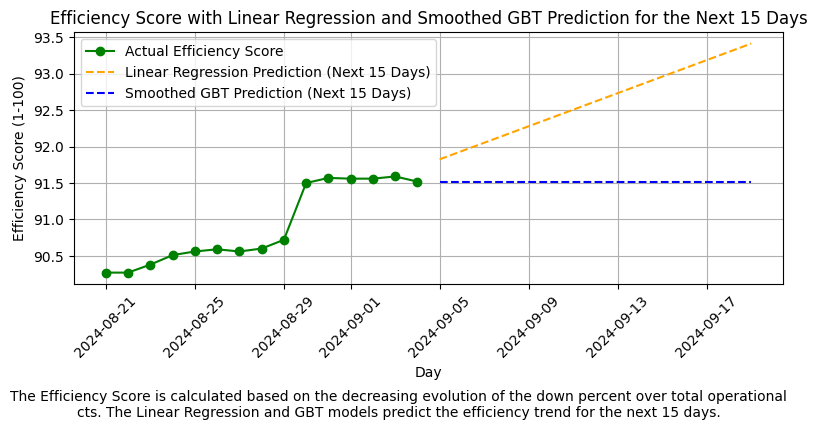

In [50]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import PolynomialExpansion
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd

# Step 18: Add polynomial features for more complexity (degree 3 in this case)
poly_expansion = PolynomialExpansion(degree=3, inputCol="features", outputCol="poly_features")
data_with_poly = poly_expansion.transform(data_for_regression)

# Step 19: Train the GBT model with polynomial features to capture more complexity
gbt = GBTRegressor(featuresCol="poly_features", labelCol="efficiency_score", maxIter=200, maxDepth=5, minInstancesPerNode=1)
gbt_model = gbt.fit(data_with_poly)

# Step 20: Transform the next 15 days for prediction (instead of 7 days)
next_15_days_poly = poly_expansion.transform(next_15_days_assembled)
gbt_predictions = gbt_model.transform(next_15_days_poly)

# Step 21: Collect predicted values for GBT and combine with original data
predicted_gbt_efficiency = gbt_predictions.select("day_index", "prediction").toPandas()

# Fix: Convert 'day' to datetime and generate next 15 days correctly for GBT
predicted_gbt_efficiency['day'] = pd.date_range(start=latest_day + timedelta(days=1), periods=15)

# Optional Smoothing: Apply a moving average to smooth the GBT predictions
predicted_gbt_efficiency['smoothed_prediction'] = predicted_gbt_efficiency['prediction'].rolling(window=2, min_periods=1).mean()

# Step 22: Plot both Linear Regression and GBT predictions for 15 days

plt.figure(figsize=(8, 4))

# Plot the actual efficiency scores
plt.plot(pandas_df['day'], pandas_df['efficiency_score'], label='Actual Efficiency Score', marker='o', color='green')

# Plot the predicted efficiency scores from Linear Regression (15 days)
plt.plot(predicted_efficiency.get('day'), predicted_efficiency.get('prediction'), label='Linear Regression Prediction (Next 15 Days)', linestyle='--', color='orange')

# Plot the smoothed GBT predictions (15 days)
plt.plot(predicted_gbt_efficiency['day'], predicted_gbt_efficiency['smoothed_prediction'], label='Smoothed GBT Prediction (Next 15 Days)', linestyle='--', color='blue')

plt.xlabel('Day')
plt.ylabel('Efficiency Score (1-100)')
plt.title('Efficiency Score with Linear Regression and Smoothed GBT Prediction for the Next 15 Days')
plt.legend()

# Add explanation text in the graph
plt.figtext(0.5, -0.05, 
            "The Efficiency Score is calculated based on the decreasing evolution of the down percent over total operational cts. "
            "The Linear Regression and GBT models predict the efficiency trend for the next 15 days.",
            wrap=True, horizontalalignment='center', fontsize=10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


